In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense    
from IPython.display import clear_output
import tensorflow as tf
clear_output() #clean tf verbose

/tmp/ipykernel_557/498904237.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['number of the week'] = df.index.weekofyear


<AxesSubplot: xlabel='date_published'>

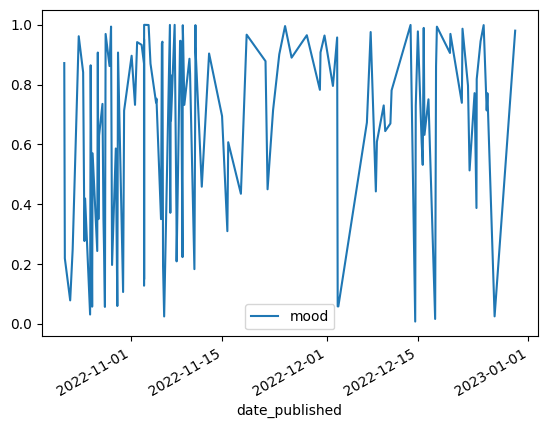

In [3]:

filename = "dataset-1672432486.csv"
df = pandas.read_csv(filename,delimiter=" ",index_col="date_published",parse_dates=True) # usecols=["author","date_published","mood"],


df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['number of the week'] = df.index.weekofyear


features = ["author","day of the week","day of the year","hour of the day","number of the week","fav_count"]
labels = ["mood"]
df = df[labels+features]


df = df.loc[df['author'] == 'JoeBiden'] # only keep JoeBiden tweets
features = ["day of the week","day of the year","hour of the day","number of the week","fav_count"] # removed author

df.drop(["author"],axis=1)
df[labels].plot() #plot mood


In [4]:

def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test

df_train, df_test = split_data(df, test_size=0.25)
scaler = MinMaxScaler().fit(df_train[features])

x_train_scaled = scaler.transform(np.asarray(df_train[features]))
x_test_scaled = scaler.transform(np.asarray(df_test[features]))

y_test = np.asarray(df_test[labels])
y_train =np.asarray(df_train[labels])

num_test = len(df_test)
num_train = len(df_train)
num_total = len(df)

print(f'Longueur totale des données: \t\t\t{len(df)}\n'+
f'Longueur totale des données de test  : \t\t{len(df_test)}\n'+
f'Longueur totale des données d"apprentissage : \t{len(df_train)}')


Longueur totale des données: 			127
Longueur totale des données de test  : 		32
Longueur totale des données d"apprentissage : 	95


/home/nathan/.local/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/nathan/.local/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [12]:
def generate_model(neurons,batch_size=1):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size,1, 5), ))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def shaper(arr):
    arr = arr.reshape(arr.shape[0],1, arr.shape[1])
    arr = np.asarray(arr).astype('float32')
    return arr

batch_size=1
model = generate_model(5,batch_size=batch_size) # 5 neurons 
X = shaper(x_train_scaled)


In [10]:
for k in range(200):
    history = model.fit(X,y_train,batch_size = 10,epochs=1)
    predictions = model.predict(X,batch_size=batch_size)
    plt.plot([x for x in range(len(predictions))],predictions,label=["prediction"])
    plt.plot([x for x in range(len(y_train))],y_train,color="green",label=["true data"])
    plt.legend()
    plt.savefig(f"fig{k}.png")
    plt.show()


95/95 [==============================] - 0s 1ms/step


In [76]:
model.evaluate(shaper(x_test_scaled),y_test,batch_size=1)

32/32 [==============================] - 0s 1ms/step - loss: 0.1456


0.14558878540992737

In [81]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [85]:

writer = tf.summary.create_file_writer('logs')
acc = history.history['loss']
for epoch in range(30):
    with writer.as_default():
        tf.summary.scalar('loss', acc[epoch], step=epoch)
